# KNN Performance Validation
### Author: Ganesh


In [1]:
import numpy as np
import pandas as pd
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import tensorflow.keras as keras

import logging
logging.getLogger('tensorflow').disabled = True
tf.autograph.set_verbosity(3)

dia_all = pd.read_csv("task1_diabetes.txt")
task2_train_data = pd.read_csv("task2_train.txt")
task2_test_data = pd.read_csv("task2_test.txt")
def getTrainData():
    return task2_train_data.copy()

def getTestData():
    return task2_test_data.copy()

def getData():
    return dia_all.copy()


## Task 1

Implement a user-defined distance function: Use “distance_cw2” as the function name. The function should calculate the distance between two give instances/records. The function takes two one-dimensional numpy arrays and returns a distance.

def distance_cw2(x, y):

Your function will calculate the Euclidean distance using m random attributes each time it is called. Use m=3

In [ ]:
 #Custom Defined function
def distance_cw2(x,y,m=3):
        randomAttributesSelected = sample(range(len(x)),k=m)
        return np.sqrt(np.sum(np.power(x[randomAttributesSelected]-y[randomAttributesSelected],2)))


class Classifier:
    #Processes the data by reprocessing and removing outlier and running prediction by given inputs
    def ProcessData(self,data,method='default',foldSplit=1,neighbors=10,display='default') :
        sourcevars = data.iloc[:,:-1] #all rows + all columns except the last one
        targetvar = data.iloc[:,-1:]
        sourcevars = self.preprocess_data(sourcevars)
        return self.KNNLearnPredict(sourcevars,targetvar,0.3,method,foldSplit,neighbors,display)

    #This is the method for preprocessing of the data
    def preprocess_data(self,data) :
        names = data.columns
        scaler = MinMaxScaler()
        return  pd.DataFrame(scaler.fit_transform(data), columns=names)
  
    #This is the predection logic This also returns the accuracy, True positive rate, precision
    def KNNLearnPredict(self,inputData,target,tSize,method,foldSplit,neighbors,display) :
        #Train Test Split
        result = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
        if foldSplit > 1 :
            cross_val = KFold(n_splits=foldSplit)
            foldNumber = 1
            for train_index, test_index in cross_val.split(inputData):
                #print(train_index,test_index)
                train_example, test_example, train_label, test_label = inputData.iloc[train_index], inputData.iloc[test_index], target.iloc[train_index], target.iloc[test_index]
                result=result.append(pd.Series(self.run(train_example,train_label,test_example,test_label,method),name=('Fold= '+str(foldNumber)+' neighbors='+str(neighbors))))
                foldNumber = foldNumber + 1    
        else:
            train_example, test_example, train_label, test_label = train_test_split(inputData,target,stratify=target)
            result=result.append(pd.Series(self.run(train_example,train_label,test_example,test_label,method),name=('method= '+method+' neighbors='+str(neighbors))))  
        return result
                           
    #Generic logic to predict and get result
    def run(self,train_example,train_label,test_example,test_label,method,neighbors=3):
        if method =='custom' :
            #KNNClassifier cliassification using custom defined function
            KNNClassifier = KNeighborsClassifier(n_neighbors=neighbors,metric=distance_cw2,metric_params={'m':3})        
        elif method == 'default':
            KNNClassifier = KNeighborsClassifier(n_neighbors=neighbors)
        else:
            KNNClassifier = KNeighborsClassifier(n_neighbors=neighbors,metric=method)
        
        #Model Fitting
        KNNClassifier.fit(train_example,np.ravel(train_label,order='C'))
    
        #Prediction
        test_prediction = KNNClassifier.predict(test_example)
        #KNNClassifier.score(test_label,test_index)
    
        #Prediction Evaluation by Accuracy, True Positive Rate, Precision
        accuracy = accuracy_score(test_label,test_prediction)
        truePositiveRate=recall_score(test_label,test_prediction,pos_label='tested_positive')
        precision = precision_score(test_label,test_prediction,pos_label='tested_positive')
        return {'Accuracy':accuracy*100,'True Positive Rate':truePositiveRate*100,'Precision':precision*100}
        
    def buildDataReport(self,result,title,xlabel="Runs",ylabel="Score",shape=(20,5),lineNeeded=False,barNeeded=True):
        
        fig = plt.gcf()
        fig.set_size_inches(shape)
        #colors = plt.cm.BuPu(np.linspace(0, 0.5, len(result.index)))
        w=0.25
        
        accuracyBar = np.arange(len(result.index))
        truePositiveBar = [i+w for i in accuracyBar]
        precisionBar = [i+w for i in truePositiveBar]
        if barNeeded:
            plt.bar(accuracyBar,result.iloc[:,0],w,label="accuracy",color='blue')
            plt.bar(truePositiveBar,result.iloc[:,1],w,label="truePositive",color='green')
            plt.bar(precisionBar,result.iloc[:,2],w,label="precision",color='orange') 
            
        
        if lineNeeded :
            plt.plot(accuracyBar,result.iloc[:,0],w,label="accuracy",color='blue')
            plt.plot(accuracyBar,result.iloc[:,1],w,label="truePositive",color='green')
            plt.plot(accuracyBar,result.iloc[:,2],w,label="precision",color='orange')
            w=0
        
        plt.ylim([0,100])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(accuracyBar+w,result.index,rotation=45)
        plt.title(title)
        plt.legend()
        plt.show()
          

def getStats(data): 
    # Correlation between the features
    data = data.replace({"class": {"tested_positive": 1, "tested_negative": 0}})
    corr = data.corr() 
    #Getting stats from Data
    stats = data.iloc[:,:-1].describe()
    #Getting additional stats from Data for outlier detection
    statsExtra = data.iloc[:,:-1].aggregate([iqr,bottomRange,upperRange])
    statsExtra.index = ['IQR','outlier_bottom_range','outlier_upper_range']
    return pd.concat([stats, statsExtra]),corr

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

def bottomRange(x):
    return x.quantile(0.25) - 1.5 * iqr(x)

def upperRange(x):
    return x.quantile(0.75) + 1.5 * iqr(x)

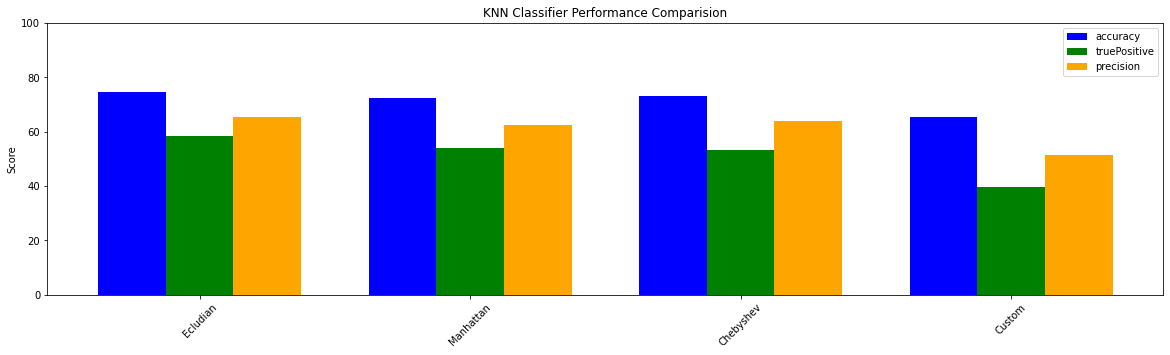

,Accuracy,True Positive Rate,Precision
Ecludian,74.475393,58.404858,65.490801
Manhattan,72.527341,54.175599,62.630057
Chebyshev,73.299727,53.230726,63.896573
Custom,65.485304,39.627223,51.422980


In [193]:
'''Use KNeighborsClassifier to evaluate the performance of your function against the following built-in distance functions:

o Euclidean

o Manhattan

o Chebyshev

'''
knn_classifier = Classifier()
 
ecludianresult = knn_classifier.ProcessData(getData(),method='euclidean',foldSplit=10).agg([np.mean])
manhattanresult = knn_classifier.ProcessData(getData(),method='manhattan',foldSplit=10).agg([np.mean])
chebyshevresult = knn_classifier.ProcessData(getData(),method='chebyshev',foldSplit=10).agg([np.mean])
result = knn_classifier.ProcessData(getData(),method='custom',foldSplit=10).agg([np.mean])

finalReport = pd.concat([ecludianresult,manhattanresult,chebyshevresult,result])
finalReport.index= ['Ecludian','Manhattan','Chebyshev','Custom']
knn_classifier.buildDataReport(finalReport,"KNN Classifier Performance Comparision",xlabel='',lineNeeded=False,barNeeded=True)
finalReport

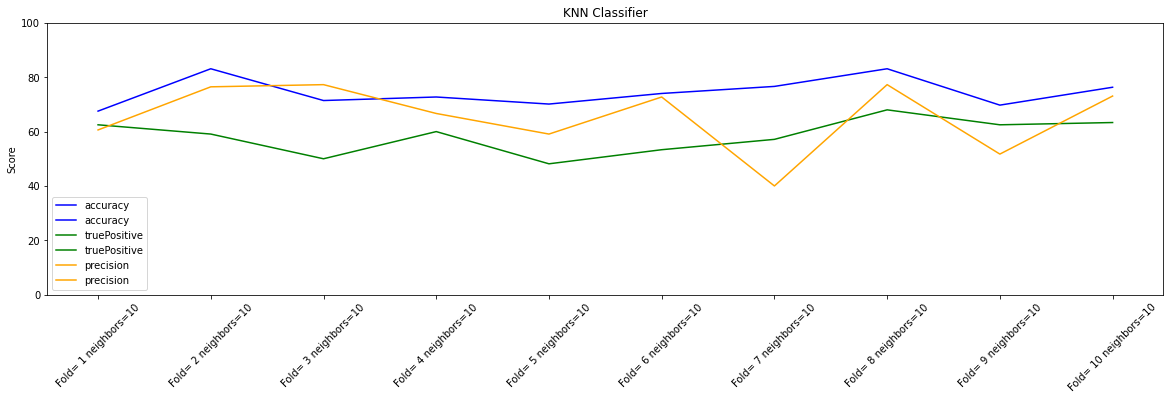

,Accuracy,True Positive Rate,Precision
mean,74.475393,58.404858,65.490801
std,5.368988,6.289912,12.532637


In [192]:
'''You should use n-fold cross-validation (where n=10). Show the results for each fold, 
the overall average and the standard deviation using relevant evaluation measures. 
You are expected to use sklearn.model_selection.KFold (i.e. don’t use cross_validate).
'''


#This uses the custom KNN class written above for reuse purpose
knn_classifier = Classifier()
data = getData() 
result = knn_classifier.ProcessData(data,foldSplit=10,method='default')
meanStd = result.agg([np.mean,np.std])
knn_classifier.buildDataReport(result,"KNN Classifier",xlabel='',lineNeeded=True,barNeeded=False)
meanStd

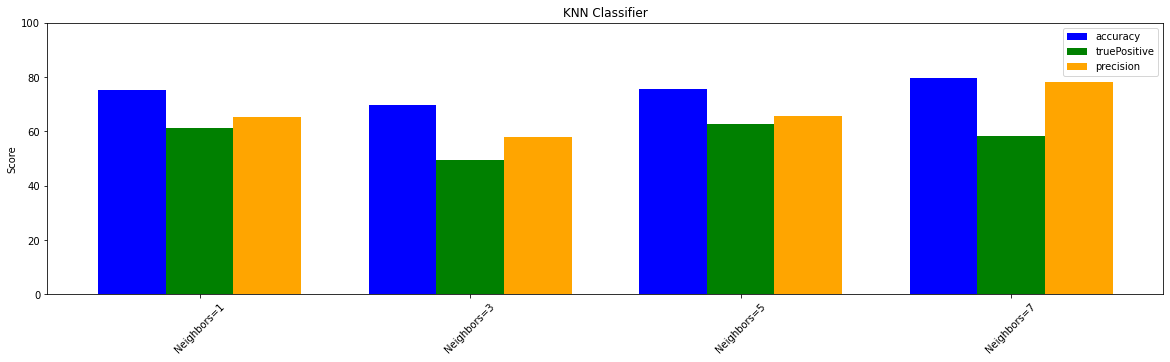

,Accuracy,True Positive Rate,Precision
Neighbors=1,75.000000,61.194030,65.079365
Neighbors=3,69.791667,49.253731,57.894737
Neighbors=5,75.520833,62.686567,65.625000
Neighbors=7,79.687500,58.208955,78.000000


In [195]:
'''Repeat the experiment using k = {1, 3, 5, 7} i.e. “k” here is the number of neighbors.'''

n=1

#This is the custom KNN classifier written above for reuse purpose
knn_classifier = Classifier()

#Results will be placed in this
result = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
for i in range(1,8,2):
    resultData = knn_classifier.ProcessData(getData(),neighbors=i).agg([np.mean])
    result = pd.concat([result,resultData])

result.index = ['Neighbors=1','Neighbors=3','Neighbors=5','Neighbors=7']
knn_classifier.buildDataReport(result,"KNN Classifier",xlabel='',lineNeeded=False,barNeeded=True)
result

   ## Taks 2

Generate noisy versions of the “task2_train.txt” dataset by randomly changing from the correct class label
to wrong ones from 0%-30% of the training instances (in increments of 2%). Evaluate the performance of KNN, DT 
and NN on the uncorrupted testing set (“task2_test.txt”). Repeat the experiment 50 times 
(i.e. using different random_state when generating the noise. Don’t change the random_state for the algorithms).

In [ ]:
tf.autograph.set_verbosity(1)
trainData = getTrainData()

'''
This method introdcues the percentage noise in the data ('class') given
'''
def generateDataNoise(data,noisePercent):
    choosenSampleData = data.sample(frac=(noisePercent/100))
    choosenSampleData.replace({"class":{0: 1, 1: 0}},inplace=True)
    data.update(choosenSampleData)
    return data


def KNNLearnPredict(train_data,test_data,neighbors) :
        train_example, test_example, train_label, test_label = train_data.iloc[:,:-1],test_data.iloc[:,:-1],train_data.iloc[:,-1:],test_data.iloc[:,-1:]

        names = train_example.columns
        scaler = MinMaxScaler()
        train_example = pd.DataFrame(scaler.fit_transform(train_example), columns=names)
        test_example = pd.DataFrame(scaler.fit_transform(test_example), columns=names)
        
        
        KNNClassifier = KNeighborsClassifier(n_neighbors=neighbors)           
        #Model Fitting
        KNNClassifier.fit(train_example,np.ravel(train_label,order='C'))
        #Prediction
        test_prediction = KNNClassifier.predict(test_example)
        #Prediction Evaluation by Accuracy, True Positive Rate, Precision
        accuracy = accuracy_score(test_label,test_prediction)
        return {'Accuracy':accuracy*100}


def decisionTreeLearnPredict(train_data,test_data) :
        train_example, test_example, train_label, test_label = train_data.iloc[:,:-1],test_data.iloc[:,:-1],train_data.iloc[:,-1:],test_data.iloc[:,-1:]
        #Decision Tree cliassification 
        treeClassifier = DecisionTreeClassifier(random_state=4)
        #Model Fitting
        treeClassifier.fit(train_example,train_label)
        #Prediction
        test_prediction = treeClassifier.predict(test_example)
        #Prediction Evaluation by Accuracy, True Positive Rate, Precision
        accuracy = accuracy_score(test_label,test_prediction)
        return {'Accuracy':accuracy*100}


def NeuralNetworkLearnPredict(train_data,test_data) :
    train_example, test_example, train_label, test_label = train_data.iloc[:,:-1],test_data.iloc[:,:-1],train_data.iloc[:,-1:],test_data.iloc[:,-1:]
    # Normalizing the data
    train_example = tf.keras.utils.normalize(train_example, axis=1)
    test_example = tf.keras.utils.normalize(test_example, axis=1)
    
    #build model
    model = tf.keras.models.Sequential()
    #Input layer
    tf.keras.backend.set_floatx('float64')
    model.add(tf.keras.layers.Flatten())
    
    #Hidden layers with first layer with 8 neurons and second layer with 3 neurons
    model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dense(3, activation=tf.nn.relu))
    
    #Output layer 2 classification
    model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax))
    
    #compile model
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    
    #Model fitting
    model.fit(train_example, train_label)
    #Validate
    loss, accuracy = model.evaluate(test_example, test_label,verbose=0,use_multiprocessing=True,workers=3)
    return {'Accuracy':accuracy*100}
    
    
    
def compare_KNN_DT_NN():
    finalResult = pd.DataFrame(columns=['KNN','DT','NN'])
    for noisePercentage in range(2,31,2):
        for runs in range(1,50) :
            train_data = generateDataNoise(getTrainData(),noisePercent=noisePercentage)        
            result = KNNLearnPredict(train_data.copy(),getTestData(),5)
            dTResult = decisionTreeLearnPredict(train_data.copy(),getTestData())
            NNResult = NeuralNetworkLearnPredict(train_data.copy(),getTestData())
            resultData = 'Noise='+str(noisePercentage)+'%, Run='+str(runs)
            finalResult = finalResult.append(pd.Series({'KNN':result['Accuracy'],'DT':dTResult['Accuracy'],'NN':NNResult['Accuracy']},name=resultData))
    report = finalResult.aggregate([np.mean])
    report.index=['Accuracy']
    return report


report = compare_KNN_DT_NN()
fig = plt.gcf()
fig.set_size_inches((20,5))
w=0.25

KNNBar = np.arange(len(report.index))
DTBar = [i+w for i in KNNBar]
NNBar = [i+w for i in DTBar]
plt.bar(KNNBar,report.iloc[:,0],w,label="KNN",color='blue')
plt.bar(DTBar,report.iloc[:,1],w,label="DT",color='green')
plt.bar(NNBar,report.iloc[:,2],w,label="NN",color='orange') 

plt.xticks(KNNBar+w,'')
plt.title('Result Comparision KNN, DT, NN')
plt.legend()
plt.show()
          
    

   ## Taks 3 [Justification]


Task1:    The experiment was performed to understand the impact of the different distance functions, Usage of Kfold 
    validation, the impact of N neighbours. The result, reflection and Interpretation:
•	Kfold validation provides us with a way to determine an excellent k-neighbourhood value by using an independent 
    data set to validate the value of k-neighbourhood.
•	There was a negative impact on the accuracy for the Custom Distance function because of the random selection of 
    the attributes when compared with the default functions like Ecudian, Manhattan, Chebyshev.

Task2:  In this case, an experiment was performed to understand the impact of the noise data on the Different 
    ML algorithms like KNN, Decision Tree, Neural Network 
•	There was more impact of the KNN and decision Tree because of the introduction of the noise data then 
    Neural Network.
Advantages:
•	KNN is called Lazy Learner (Instance-based learning). It does not learn anything in the training period. 
    This makes the KNN algorithm training much faster than other algorithms that require training.
•	Compared to other algorithms Decision trees requires less effort for data preparation during pre-processing. 
    It does not require normalization or feature scaling of data.
•	Impact of the noise on the neural network is less compared to the other methodologies used here.  After training, 
    the data may produce output even with incomplete information. The loss of performance here depends on the 
    importance of the missing information.
Limitation 
•	KNN: In large datasets, the cost of calculating the distance between the new point and each existing points 
    is enormous, which degrades the performance of the algorithm. We need to do feature scaling before applying 
    the KNN algorithm to any dataset. KNN is sensitive to noise in the dataset. 
•	Decision Tree: A small change in the data can cause a large change in the structure of the decision tree, 
    causing instability. It involves higher time to train the model
•	Incase of Neural network Time to process and more computational power needed.

· Possible improvements.
Choosing the optimal value for k-neighbourhood is best done by first inspecting the data. 
In general, a large k-neighbourhood value is more precise as it reduces the overall noise 
,but there is no guarantee. Cross-validation is another way to determine a good k-neighbourhood 
value by using an independent data set to validate the value of k-neighbourhood.

